## Data Preprocessing
: 분석에 이용할 연도별 팀투수 및 팀타자 데이터의 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. 파생변수 생성

투수/타자 평가에 사용되는 여러 지표들을 계산 후 사용. 
지표 계산에 사용되는 연도별 상수들은 조사 후, 기존에 계산된 값들을 찾아 사용함.

- 투수: K/9, BB/9, K/BB, OAVG, OOBP, OSLG, OOPS, WHIP, BABIP, DICE, ERA, RA9, FIP, kFIP, HR/9, H/9 
- 타자: AVG, SLG, IsoP, OBP, OPS, RC, XR, wOBA, BABIP

In [2]:
# 투수/ 타자 파생변수 생성 위한 연도별 상수들을 데이터프레임 형태로, idx_pit 및 idx_hit이라는 이름으로 저장
idx_pit= pd.DataFrame({'GYEAR': [2020, 2019, 2018, 2017, 2016], 'cFIP': [3.597, 3.403, 3.833, 3.735, 3.792]})
idx_pit

,GYEAR,cFIP
0,2020,3.597
1,2019,3.403
2,2018,3.833
3,2017,3.735
4,2016,3.792


In [3]:
idx_hit = pd.DataFrame({'GYEAR': [2020, 2019, 2018, 2017, 2016], 'wBB': [0.733, 0.721, 0.726, 0.728, 0.747],
                       'wHBP': [0.761, 0.752, 0.753, 0.756, 0.774], 'w1B': [0.939, 0.945, 0.920, 0.927, 0.944],
                       'w2B': [1.282, 1.317, 1.242, 1.259, 1.273], 'w3B': [1.592, 1.653, 1.533, 1.558, 1.569],
                       'wHR': [1.950, 2.074, 1.857, 1.901, 1.898]})
idx_hit

,GYEAR,wBB,wHBP,w1B,w2B,w3B,wHR
0,2020,0.733,0.761,0.939,1.282,1.592,1.950
1,2019,0.721,0.752,0.945,1.317,1.653,2.074
2,2018,0.726,0.753,0.920,1.242,1.533,1.857
3,2017,0.728,0.756,0.927,1.259,1.558,1.901
4,2016,0.747,0.774,0.944,1.273,1.569,1.898


In [4]:
#투수 파생변수 생성 함수 정의
def add_variables_pit(data, year):
    data = pd.read_csv(data)
    data['H1']= data['HIT']-data['H2']-data['H3']-data['HR']
    
    data.loc[data['G_ID'].str.contains('%d' % year), 'GYEAR'] = year
    data = pd.merge(data, idx_pit, on='GYEAR')
    
    data = data.sort_values(by=['T_ID', 'GDAY_DS'])
    data= data.drop('GYEAR', axis=1 )

    data = data.sort_index()

    data['K/9'] = 9*data['KK']/(data['INN2']/3)
    data['BB/9'] = 9*data['BB']/(data['INN2']/3)
    data['K/BB'] = data['KK']/data['BB']
    data['OAVG'] = data['HIT']/data['AB']
    data['OOBP'] = (data['HIT'] + data['BB'] + data['HP'])/(data['AB'] + data['BB'] +data['HP'] + data['SF'])
    data['OSLG'] = (data['H1'] + 2*data['H2'] + 3*data['H3'] + 4*data['HR'])/data['AB']
    
    data = data.replace([np.nan, np.inf, -np.inf], 0)
    data['OOPS'] = data['OOBP'] + data['OSLG']
    data['WHIP'] = (data['HIT'] + data['BB'])/(data['INN2']/3)
    data['BABIP'] = (data['HIT'] - data['HR'])/(data['AB'] - data['KK'] - data['HR'] + data['SF'])
    data['DICE']= 3.00 + (13*data['HR'] + 3*(data['BB'] + data['HP']) - 2*data['KK'])/(data['INN2']/3)
    data['ERA'] = 9*data['ER']/(data['INN2']/3)
    data['RA9'] = 9 * data['R']/(data['INN2']/3)
    data['FIP'] = data['cFIP'] + (13*data['HR'] + 3*(data['BB'] + data['HP']) - 2*data['KK'])/(data['INN2']/3)
    data['kFIP'] = data['cFIP'] + (14* data['HR'] + 3*(data['BB'] + data['HP']) - data['KK'])/(data['INN2']/3)
    data['HR/9'] = 9 * data['HR']/(data['INN2']/3)
    data['H/9'] = 9 * data['HIT']/(data['INN2']/3)

    data = data.replace([np.nan, np.inf, -np.inf], 0)
    data = data.drop(['cFIP'],axis=1)
    data=data[['G_ID', 'GDAY_DS', 'T_ID', 'VS_T_ID', 'HEADER_NO', 'TB_SC', 'CG_CK',
       'WLS', 'HOLD', 'INN2', 'BF', 'PA', 'AB', 'HIT','H1', 'H2', 'H3', 'HR', 'SB',
       'CS', 'SH', 'SF', 'BB', 'IB', 'HP', 'KK', 'GD', 'WP', 'BK', 'ERR', 'R',
       'ER', 'P_WHIP_RT', 'P2_WHIP_RT', 'CB_WHIP_RT', 'K/9', 'BB/9',
       'K/BB', 'OAVG', 'OOBP', 'OSLG', 'OOPS', 'WHIP', 'BABIP', 'DICE', 'ERA',
       'RA9', 'FIP', 'kFIP', 'HR/9', 'H/9']]
    data.to_csv('team_pitcher_%d.csv' % year, index=False)

In [5]:
#투수 파생변수 계산 함수 적용, 저장
add_variables_pit('2020빅콘테스트_스포츠투아이_제공데이터_팀투수_2016.csv', 2016)
add_variables_pit('2020빅콘테스트_스포츠투아이_제공데이터_팀투수_2017.csv', 2017)
add_variables_pit('2020빅콘테스트_스포츠투아이_제공데이터_팀투수_2018.csv', 2018)
add_variables_pit('2020빅콘테스트_스포츠투아이_제공데이터_팀투수_2019.csv', 2019)
add_variables_pit('2020빅콘테스트_스포츠투아이_제공데이터_팀투수_2020.csv', 2020)

In [6]:
#타자 파생변수 생성함수 정의
def add_variables_hit(data, year):
    data = pd.read_csv(data)
    data['H1']= data['HIT']- data['H2'] - data['H3'] - data['HR']
    
    data.loc[data['G_ID'].str.contains('%d' % year), 'GYEAR'] = year
    data = pd.merge(data, idx_hit, on='GYEAR')
    
    data = data.sort_values(by=['T_ID', 'G_ID'])
    data= data.drop('GYEAR', axis=1 )
    
    data['AVG'] = data['HIT']/ data['AB']
    data['SLG'] = (data['H1']+ 2 * data['H2']+ 3 * data['H3'] + 4 *data['HR']) / data['AB']
    data = data.replace([np.nan, np.inf, -np.inf], 0)
    data['IsoP']= data['SLG']- data['AVG']               
    data['OBP']= (data['HIT'] + data['BB'] + data['HP'])/(data['AB']+data['BB']+data['HP']+data['SF'])
    data = data.replace([np.nan, np.inf, -np.inf], 0)
    data['OPS'] = data['OBP']+ data['SLG']
    
    data['RC']= ((data['HIT']+ data['BB']+ data['HP']-data['CS']-data['GD']) *  ((data['H1']+ 2 * data['H2'] + 3 * data['H3'] + 4 * data['HR']) + 0.52 * (data['SB']+data['SH']+data['SF']) + 0.26 * (data['BB']+ data['HP'] -data['IB'])))/(data['AB']+data['BB']+data['HP']+data['SH']+data['SF'])
    data['XR']= 0.5*data['H1'] + 0.72*data['H2']+ 1.04 *data['H3'] + 1.44 *data['HR'] + 0.34* (data['HP']+data['BB']-data['IB'])+ 0.25* data['IB'] + 0.18 * data['SB'] - 0.32*data['CS'] - 0.09 * (data['AB'] -data['HIT']-data['KK']) - 0.098 * data['KK'] -0.37 *data['GD'] + 0.37* data['SF']+ 0.04* data['SH']
    data['wOBA']= (data['wBB'] * (data['BB']-data['IB']) + data['wHBP']*data['HP'] + data['w1B']*data['H1']+data['w2B']* data['H2'] + data['w3B'] * data['H3'] +data['wHR']*data['HR'])/(data['AB']+data['BB']-data['IB']+ data['SF']+ data['HP'])
    data['wOBA']= (data['wBB'] * (data['BB']-data['IB']) + data['wHBP']*data['HP'] + data['w1B']*data['H1']+data['w2B']* data['H2'] + data['w3B'] * data['H3'] +data['wHR']*data['HR'])/(data['PA']-data['IB'])
    data['BABIP']= (data['HIT'] - data['HR']) / (data['AB']-data['KK']-data['HR']+data['SF'])
    
    data = data.replace([np.nan, np.inf, -np.inf], 0)
    data = data.drop(['wBB','wHBP','w1B','w2B','w3B','wHR'],axis=1)
    data = data[['G_ID', 'GDAY_DS', 'T_ID', 'VS_T_ID', 'HEADER_NO', 'TB_SC', 'PA', 'AB',
       'RBI', 'RUN', 'HIT','H1', 'H2', 'H3', 'HR', 'SB', 'CS', 'SH', 'SF', 'BB',
       'IB', 'HP', 'KK', 'GD', 'ERR', 'LOB', 'P_HRA_RT', 'P_AB_CN', 'P_HIT_CN',
       'AVG', 'SLG', 'IsoP', 'OBP', 'OPS', 'RC', 'XR', 'wOBA', 'BABIP']]
    
    data.to_csv('team_batter_%d.csv' % year, index=False)

In [7]:
#타자 파생변수 계산 함수 적용, 저장
add_variables_hit('2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2016.csv', 2016)
add_variables_hit('2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2017.csv', 2017)
add_variables_hit('2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2018.csv', 2018)
add_variables_hit('2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2019.csv', 2019)
add_variables_hit('2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2020.csv', 2020)

In [8]:
#투수 데이터 병합; 연도별 팀투수 데이터를 tpit이라는 이름으로 하나의 데이터로 병합.
pit16 = pd.read_csv('team_pitcher_2016.csv')
pit17 = pd.read_csv('team_pitcher_2017.csv')
pit18 = pd.read_csv('team_pitcher_2018.csv')
pit19 = pd.read_csv('team_pitcher_2019.csv')
pit20 = pd.read_csv('team_pitcher_2020.csv')

pit = pd.concat([pit16, pit17, pit18, pit19, pit20],axis=0)


#타자 데이터 병합; 연도별 팀타자 데이터를 thit이라는 이름으로 하나의 데이터로 병합.
hit16 = pd.read_csv('team_batter_2016.csv')
hit17 = pd.read_csv('team_batter_2017.csv')
hit18 = pd.read_csv('team_batter_2018.csv')
hit19 = pd.read_csv('team_batter_2019.csv')
hit20 = pd.read_csv('team_batter_2020.csv')

hit = pd.concat([hit16, hit17, hit18, hit19, hit20],axis=0)

### 2. Check NAs
: 확인결과 타자/투수 데이터 모두 NA값 없음을 확인

In [9]:
pit.isnull().sum()

G_ID          0
GDAY_DS       0
T_ID          0
VS_T_ID       0
HEADER_NO     0
TB_SC         0
CG_CK         0
WLS           0
HOLD          0
INN2          0
BF            0
PA            0
AB            0
HIT           0
H1            0
H2            0
H3            0
HR            0
SB            0
CS            0
SH            0
SF            0
BB            0
IB            0
HP            0
KK            0
GD            0
WP            0
BK            0
ERR           0
R             0
ER            0
P_WHIP_RT     0
P2_WHIP_RT    0
CB_WHIP_RT    0
K/9           0
BB/9          0
K/BB          0
OAVG          0
OOBP          0
OSLG          0
OOPS          0
WHIP          0
BABIP         0
DICE          0
ERA           0
RA9           0
FIP           0
kFIP          0
HR/9          0
H/9           0
dtype: int64

In [10]:
hit.isnull().sum()

G_ID         0
GDAY_DS      0
T_ID         0
VS_T_ID      0
HEADER_NO    0
TB_SC        0
PA           0
AB           0
RBI          0
RUN          0
HIT          0
H1           0
H2           0
H3           0
HR           0
SB           0
CS           0
SH           0
SF           0
BB           0
IB           0
HP           0
KK           0
GD           0
ERR          0
LOB          0
P_HRA_RT     0
P_AB_CN      0
P_HIT_CN     0
AVG          0
SLG          0
IsoP         0
OBP          0
OPS          0
RC           0
XR           0
wOBA         0
BABIP        0
dtype: int64

### 3. Feature Selection: remove correlated variables

**Variable Selection Criteria**
1. 상관계수 0.9 이상 변수
2. 상관관계가 0.9 이상인, 기존변수 vs. 파생변수 $\rightarrow$ 기존변수를 남기고, 파생변수를 제거
3. 상관관계가 0.9 이상인,기존변수 vs. 기존변수 or 파생변수 vs. 파생변수 $\rightarrow$ 주관적 판단에 의해 변수선택

***1) 투수 데이터(Team Pitchers data)***

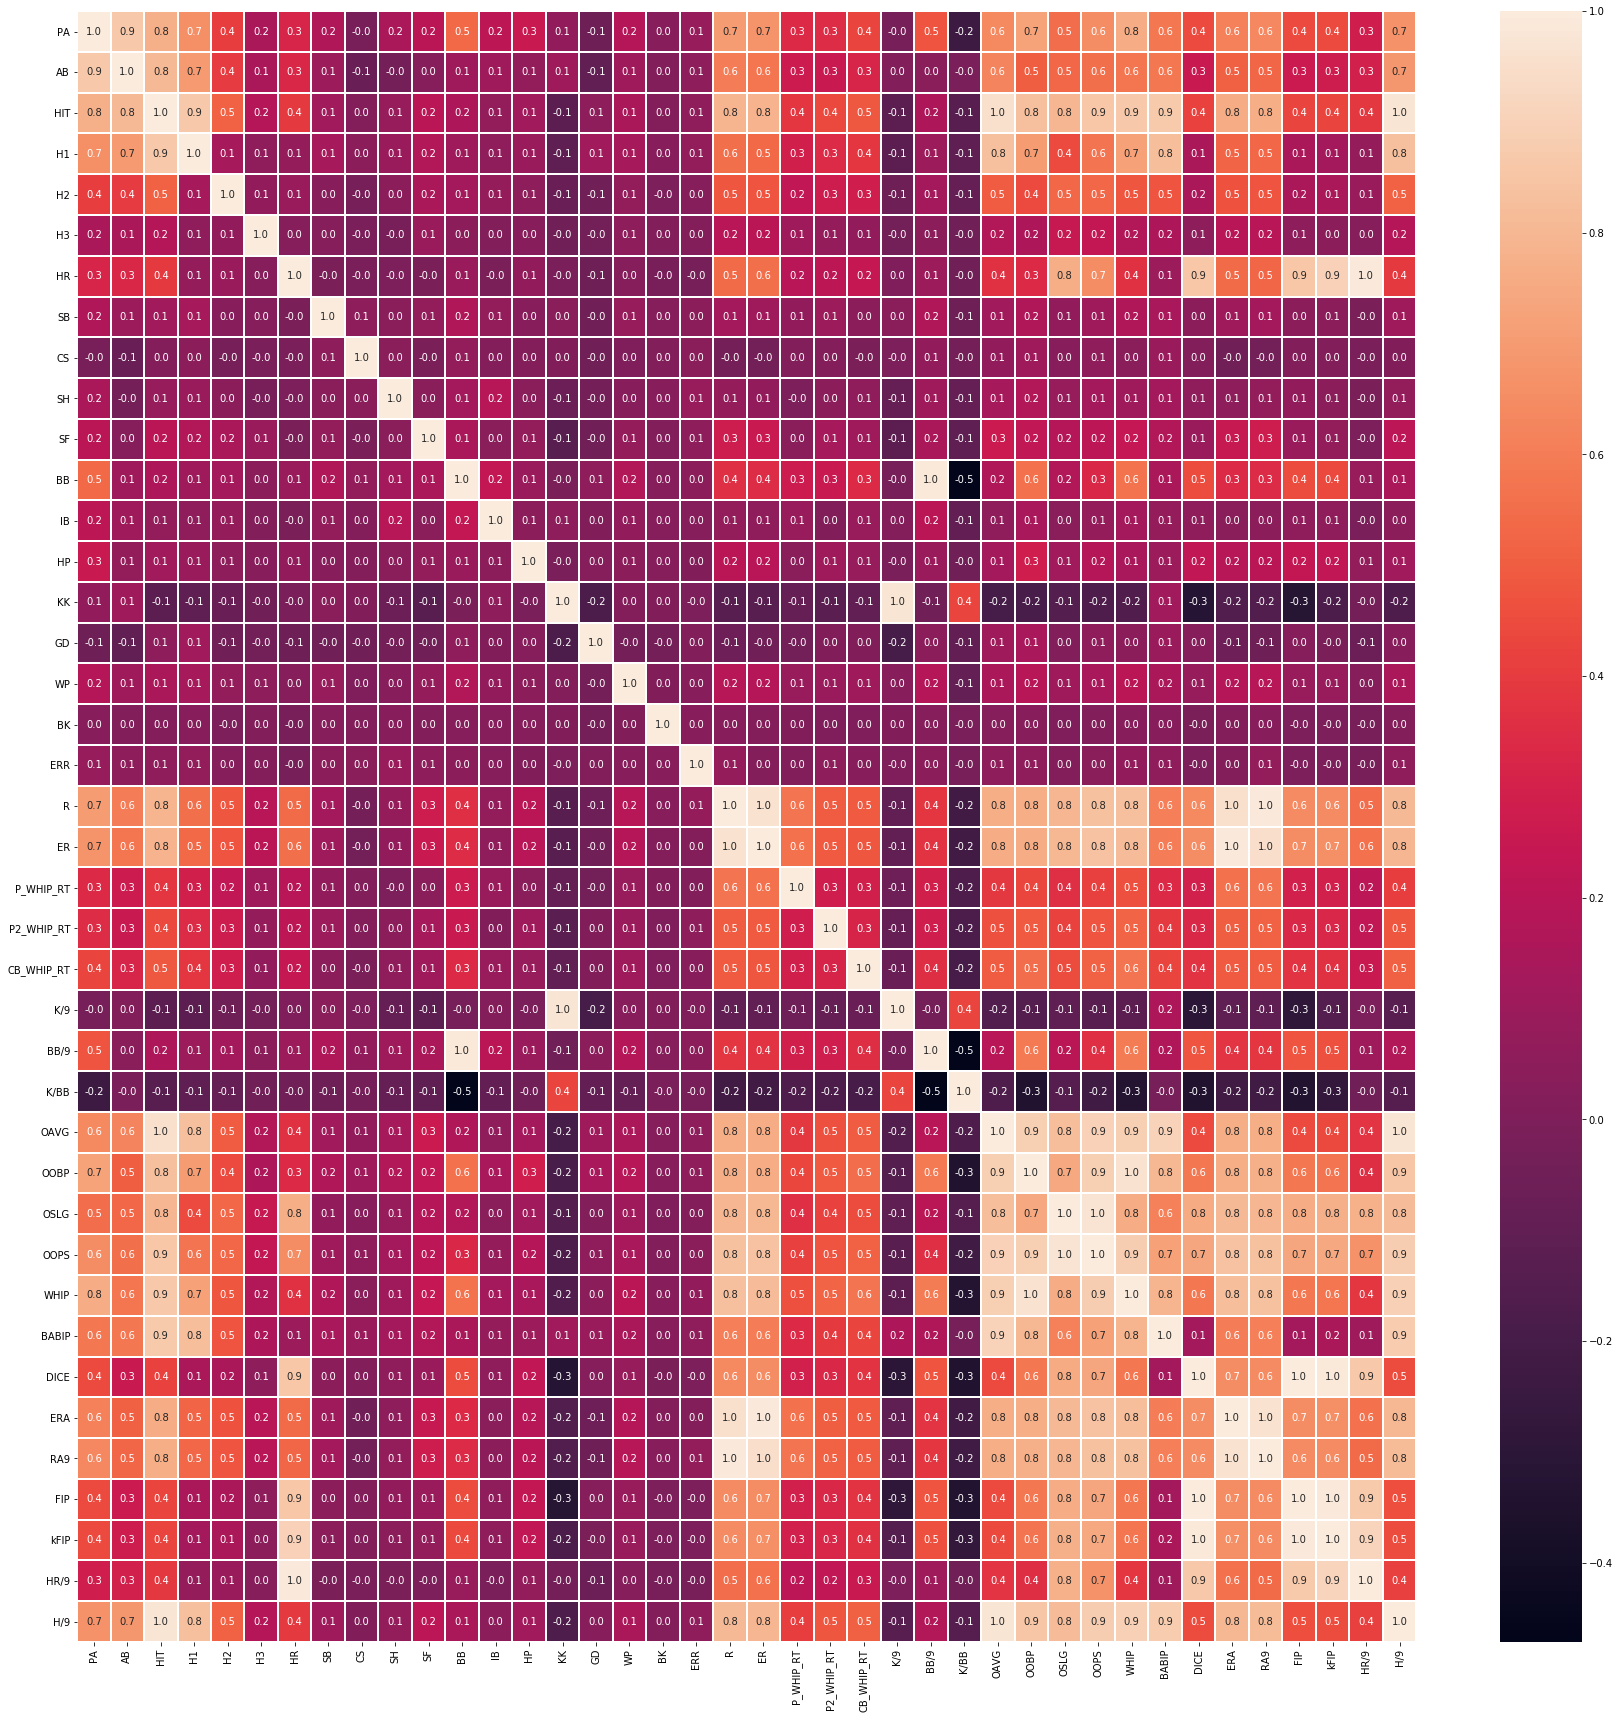

In [11]:
col = ['G_ID', 'GDAY_DS', 'T_ID', 'VS_T_ID', 'HEADER_NO', 'TB_SC', 'CG_CK','WLS', 'HOLD', 'INN2', 'BF']
data_cor = pit.drop(col,axis=1)
fig, ax = plt.subplots(figsize=(30,30))
ax = sns.heatmap(data_cor.corr(), annot=True, fmt='.1f',linewidth=1)

**High-Correlated Variables**

- PA와 AB$\rightarrow$ 보류, 일단 둘다 사용
- kFIP, FIP, DICE: 계산 과정에서 계수에 약간에 차이를 둔 FIP 계열의 지표들. $\rightarrow$ kFIP만 사용
- OAVG, OOBP, OSLG, OOPS, WHIP $\rightarrow$ OOPS, WHIP만 사용

**$\rightarrow$ Feature Selection 결과**: kFIP, OOPS, WHIP, BABIP, K/BB와 기존 변수들.

In [12]:
pit = pit.drop(['K/9','BB/9','OAVG','OOBP','OSLG','DICE','ERA','RA9','FIP','HR/9','H/9'],axis=1)

***2) 타자 데이터(Team Hitters data)***

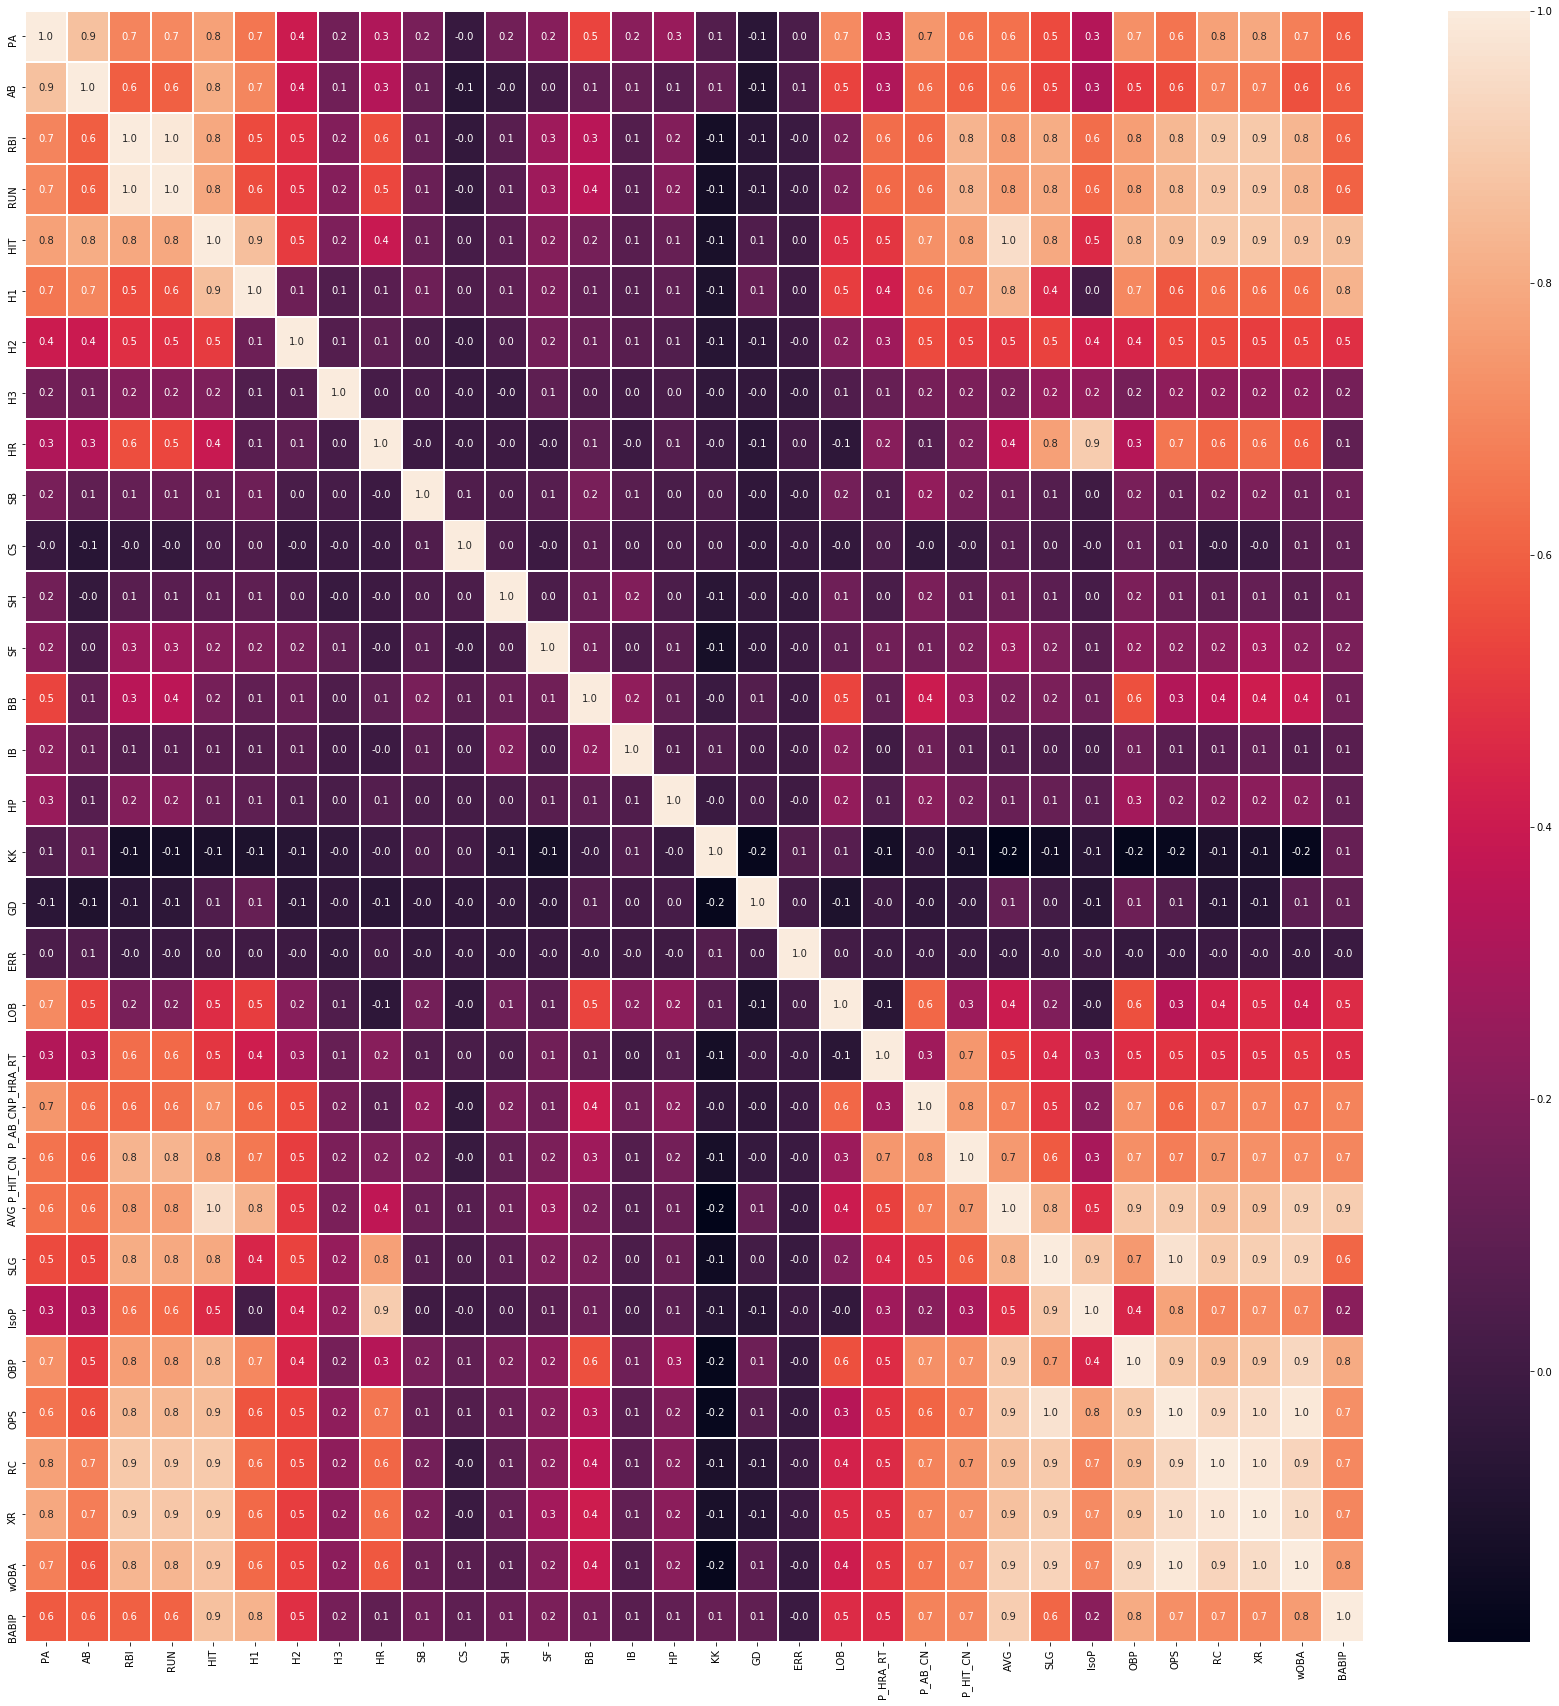

In [13]:
col = ['G_ID', 'GDAY_DS', 'T_ID', 'VS_T_ID', 'HEADER_NO', 'TB_SC']
data_cor = hit.drop(col, axis=1)
fig, ax = plt.subplots(figsize=(30,30))
ax = sns.heatmap(data_cor.corr(), annot=True, fmt='.1f',linewidth=1)

**High-Correlated Variables**

- PA(타자수) vs. AB(타수) $\rightarrow$ 보류, 둘다 보존
- AVG(타율) vs. SLG(장타율), OBP(출루율), OPS(장타율+출루율), wOBA(가중출루율), BABIP $\rightarrow$ AVG(타율)만 보존
- IsoP(순장타율) 보존
- RC(득점기여도) vs. XR(득점공헌도) $\rightarrow$ XR 선택

**$\rightarrow$ Feature Selection 결과**: 파생변수 중에서는 XR, OPS, IsoP, BABIP만 선택, 기존변수는 그대로 사용


- 의미가 없다고 판단되는 변수: LOB(잔루) $\rightarrow$ 제거

In [14]:
hit = hit.drop(['AVG','SLG','OBP','RC','wOBA', 'LOB'],axis=1)

### 4. Scaling & Dummy화

***1) 투수 데이터 (Team Pitchers data)***
- AB(타수), HIT(안타), H1, H2, H3, HR, SH(희타), SF(희플), BB(볼넷), HP(사구), KK(삼진) 등은 타석에 포함됨  $\rightarrow$ PA(타석)으로 나누어서 경기별로 scaling 시킴
- PA(타석), P_WHIP_RT, K/BB, kFIP, WHIP, ERR(실책), GD(병살타), OOPS,BF(투구수)  $\rightarrow$ MinMaxScaler 사용
- BABIP은 이미 0~1사이의 값을 가지기 때문에 따로 스케일링하지 않음.
- HEADER_NO(더블해더), TB_SC(초/말), WB(폭투), BK(보크)  $\rightarrow$ dummy화
- SB(도루성공),CS(도루실패)$\rightarrow$ 두 변수 모두 삭제, 대신 도루 실패율을 나타내는 'CS_%'(도루실패율) 열 추가.

In [15]:
# 타석으로 나누어 Scaling
col = ['AB','HIT','H1','H2','H3','HR','SH','SF','BB','IB','HP','KK']
for i in range(len(col)):
    pit.loc[:,col[i]] = pit.loc[:,col[i]]/pit.loc[:,'PA']

In [16]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(pit[['PA','P_WHIP_RT','P2_WHIP_RT','CB_WHIP_RT','K/BB','kFIP','WHIP','ERR','GD','OOPS','BF']])
pit.loc[:,['PA','P_WHIP_RT','P2_WHIP_RT','CB_WHIP_RT','K/BB','kFIP','WHIP','ERR','GD','OOPS','BF']] = scaler.transform(pit[['PA','P_WHIP_RT','P2_WHIP_RT','CB_WHIP_RT','K/BB','kFIP','WHIP','ERR','GD','OOPS','BF']])

In [17]:
print(pit.WP.value_counts()) #WP(폭투)의 경우 2이상의 폭투 여부 (0,1)로 dummy화하는 것이 낫다고 판단.
print(pit.BK.value_counts()) #BK(보크)의 경우 2이상의 폭투 여부 (0,1)로 dummy화하는 것이 낫다고 판단.

0    4135
1    1704
2     443
3      98
4      19
5       1
Name: WP, dtype: int64
0    6199
1     197
2       4
Name: BK, dtype: int64


In [18]:
# dummy화
pit['WP'] = pit['WP'].replace([1,2,3,4,5],1)    # 폭투 여부를 0,1로 더미화    
pit['BK'] = pit['BK'].replace([1,2],1) # 보크 여부를 0,1로 더미화
pit=pd.get_dummies(pit, columns=['HEADER_NO','TB_SC'],  drop_first=True)

In [19]:
# SB(도루성공) 과 CS(SF)도루 실패 ==> 도루 실패율로
# 도루 시도 횟수가 모두 0이라 실패율을 계산할 수 없는 경우에는 시즌 내 팀의 도루실패율 평균값으로 대체.
pit['CS_%']= pit['CS']/(pit['SB']+pit['CS'])

T_id= pit['T_ID'].unique()
pit['CS_%']=pit['CS_%'].replace([np.inf, -np.inf], np.nan)

for i in range(5):
    for j in range(len(T_id)):
        mean= np.mean( pit.loc[(pit['G_ID'].str.contains(str(2016+i)))&(pit['T_ID']==T_id[j]),'CS_%']  )
        pit.loc[(pit['T_ID']==T_id[j])&(pit['G_ID'].str.contains(str(2016+i))),'CS_%']=pit.loc[(pit['T_ID']==T_id[j])&(pit['G_ID'].str.contains(str(2016+i))),'CS_%'].replace([np.nan], mean)
        
pit=pit.drop(['CS','SB'],axis=1)

***2) 타자 데이터 (Team Hitters Data)***
- 타석(PA)에 포함되는 AB,HIT(안타수), H1, H2, H3, HR, SH(희타),SF(희비),BB(볼넷),HP(사구), KK(삼진)$\rightarrow$ 타석으로 나누어 scaling
- PA(타석), XR(추정득점), GD(병살타), ERR(실책), OPS $\rightarrow$ MinMaxScaler사용
- 이미 0~1사이 값을 갖는 IsoP, BABIP, PA_HRA_RT(득점권 타율)은 따로 scaling하지 않음.
- HEADER_NO(더블헤더), TB_SC(초/말) dummy화
- SB(도루성공),CS(도루실패)$\rightarrow$ 두 변수 모두 삭제, 대신 도루 실패율을 나타내는 'CS_%'(도루실패율) 열 추가.

In [20]:
# 타석으로 나누어 Scaling
col = ['AB','HIT','H1','H2','H3','HR','SH','SF','BB','HP','IB','KK','P_AB_CN', 'P_HIT_CN']
for i in range(len(col)):
    hit.loc[:,col[i]] = hit.loc[:,col[i]]/hit.loc[:,'PA']

In [21]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(hit[['PA','XR','GD','ERR','OPS']])
hit.loc[:,['PA','XR','GD','ERR','OPS']] = scaler.transform(hit[['PA','XR','GD','ERR','OPS']])

In [22]:
# HEADER_NO, TB_SC dummy화
hit=pd.get_dummies(hit, columns=['HEADER_NO','TB_SC'],  drop_first=True)

In [23]:
# SB(도루성공) 과 CS(SF)도루 실패 ==> 도루 실패율로
# 도루 시도 횟수가 모두 0이라 실패율을 계산할 수 없는 경우에는 시즌 내 팀의 도루실패율 평균값으로 대체.
hit['CS_%']= hit['CS']/(hit['SB']+hit['CS'])

T_id= hit['T_ID'].unique()
hit['CS_%']=hit['CS_%'].replace([np.inf, -np.inf], np.nan)

for i in range(5):
    for j in range(len(T_id)):
        mean= np.mean( hit.loc[(hit['G_ID'].str.contains(str(2016+i)))&(hit['T_ID']==T_id[j]),'CS_%']  )
        hit.loc[(hit['T_ID']==T_id[j])&(hit['G_ID'].str.contains(str(2016+i))),'CS_%']=hit.loc[(hit['T_ID']==T_id[j])&(hit['G_ID'].str.contains(str(2016+i))),'CS_%'].replace([np.nan], mean)
        
hit=hit.drop(['CS','SB'],axis=1)

### 5. 기타 처리
- 무승부의 경우 16~20 시즌을 모두 합해 팀기준 경기수 66개 (즉 총 33경기만 무승부)이므로 승/패 예측을 위해 제외하기.

In [24]:
#데이터 정렬
pit=pit.sort_values(by=['G_ID', 'T_ID']).reset_index(drop=True)
hit= hit.sort_values(by=['G_ID', 'T_ID']).reset_index(drop=True)

In [25]:
#16~20년도 경기 중, 주어진 데이터에서 무승부는 단 66경기뿐.
#무승부 경기는 예측을 위해 제외하고 생각하기.
temp= []
for i in range(len(pit['WLS'])):
    if pit.loc[i,'WLS']!='D' :
        temp.append(i)
pit=pit.iloc[temp,:].reset_index(drop=True)
hit=hit.iloc[temp,:].reset_index(drop=True)

In [26]:
#GDAY_DS는 날짜형식으로 바꿔주기
pit['GDAY_DS']=pd.to_datetime(pit['GDAY_DS'].astype('str'))
hit['GDAY_DS']=pd.to_datetime(hit['GDAY_DS'].astype('str'))

In [27]:
#투수,타자 지표들을 통합해 total이라는 이름으로 저장.
total=pd.merge(pit,hit, on=['G_ID', 'GDAY_DS', 'T_ID', 'VS_T_ID','HEADER_NO_1', 'HEADER_NO_2', 'TB_SC_T'])

In [28]:
total.columns=['G_ID', 'GDAY_DS', 'T_ID', 'VS_T_ID', 'CG_CK', 'WLS', 'HOLD', 'INN2',
       'BF', 'PIT_PA', 'PIT_AB', 'PIT_HIT', 'PIT_H1', 'PIT_H2', 'PIT_H3', 'PIT_HR', 'PIT_SH',
       'PIT_SF', 'PIT_BB', 'PIT_IB', 'PIT_HP', 'PIT_KK', 'PIT_GD', 'WP', 'BK', 'PIT_ERR',
       'R', 'ER', 'P_WHIP_RT', 'P2_WHIP_RT', 'CB_WHIP_RT', 'K/BB', 'OOPS',
       'WHIP', 'PIT_BABIP', 'kFIP', 'HEADER_NO_1', 'HEADER_NO_2', 'TB_SC_T',
       'PIT_CS_%', 'HIT_PA', 'HIT_AB', 'RBI', 'RUN', 'HIT_HIT', 'HIT_H1', 'HIT_H2', 'HIT_H3',
       'HIT_HR', 'HIT_SH', 'HIT_SF', 'HIT_BB', 'HIT_IB', 'HIT_HP', 'HIT_KK', 'HIT_GD', 'HIT_ERR',
       'P_HRA_RT', 'P_AB_CN', 'P_HIT_CN', 'IsoP', 'OPS', 'XR', 'HIT_BABIP',
       'HIT_CS_%']
total.head()

,G_ID,GDAY_DS,T_ID,VS_T_ID,CG_CK,WLS,HOLD,INN2,BF,PIT_PA,...,HIT_GD,HIT_ERR,P_HRA_RT,P_AB_CN,P_HIT_CN,IsoP,OPS,XR,HIT_BABIP,HIT_CS_%
0,20160401HHLG0,2016-04-01,HH,LG,0,L,0,34,0.643192,0.625000,...,0.2,0.4,0.200000,0.288462,0.057692,0.043478,0.380287,0.287095,0.361111,0.410714
1,20160401HHLG0,2016-04-01,LG,HH,0,W,0,36,0.586854,0.729167,...,0.0,0.0,0.333333,0.255319,0.085106,0.119048,0.356391,0.270375,0.266667,0.333333
2,20160401HTNC0,2016-04-01,HT,NC,0,L,0,24,0.413146,0.395833,...,0.2,0.0,0.100000,0.263158,0.026316,0.176471,0.429113,0.266510,0.304348,0.375947
3,20160401HTNC0,2016-04-01,NC,HT,0,W,0,27,0.394366,0.437500,...,0.2,0.2,0.142857,0.194444,0.027778,0.266667,0.584911,0.352966,0.368421,0.328903
4,20160401KTSK0,2016-04-01,KT,SK,0,W,0,27,0.413146,0.395833,...,0.0,0.0,0.285714,0.166667,0.047619,0.166667,0.510963,0.393127,0.321429,0.333333


In [29]:
pit.head()

,G_ID,GDAY_DS,T_ID,VS_T_ID,CG_CK,WLS,HOLD,INN2,BF,PA,...,CB_WHIP_RT,K/BB,OOPS,WHIP,BABIP,kFIP,HEADER_NO_1,HEADER_NO_2,TB_SC_T,CS_%
0,20160401HHLG0,2016-04-01,HH,LG,0,L,0,34,0.643192,0.625000,...,0.062500,0.196429,0.356391,0.250296,0.266667,0.186481,0,0,1,0.333333
1,20160401HHLG0,2016-04-01,LG,HH,0,W,0,36,0.586854,0.729167,...,0.200000,0.238095,0.380287,0.295302,0.361111,0.100347,0,0,0,0.419478
2,20160401HTNC0,2016-04-01,HT,NC,0,L,0,24,0.413146,0.395833,...,0.156250,0.128571,0.584911,0.395973,0.368421,0.365653,0,0,1,0.300694
3,20160401HTNC0,2016-04-01,NC,HT,0,W,0,27,0.394366,0.437500,...,0.178571,0.238095,0.429113,0.268456,0.304348,0.214293,0,0,0,0.381818
4,20160401KTSK0,2016-04-01,KT,SK,0,W,0,27,0.413146,0.395833,...,0.022727,0.000000,0.461837,0.241611,0.321429,0.153068,0,0,1,0.376111


In [30]:
hit.head()

,G_ID,GDAY_DS,T_ID,VS_T_ID,PA,AB,RBI,RUN,HIT,H1,...,P_AB_CN,P_HIT_CN,IsoP,OPS,XR,BABIP,HEADER_NO_1,HEADER_NO_2,TB_SC_T,CS_%
0,20160401HHLG0,2016-04-01,HH,LG,0.729167,0.884615,4,4,0.250000,0.211538,...,0.288462,0.057692,0.043478,0.380287,0.287095,0.361111,0,0,1,0.410714
1,20160401HHLG0,2016-04-01,LG,HH,0.625000,0.893617,4,5,0.191489,0.127660,...,0.255319,0.085106,0.119048,0.356391,0.270375,0.266667,0,0,0,0.333333
2,20160401HTNC0,2016-04-01,HT,NC,0.437500,0.894737,3,4,0.210526,0.105263,...,0.263158,0.026316,0.176471,0.429113,0.266510,0.304348,0,0,1,0.375947
3,20160401HTNC0,2016-04-01,NC,HT,0.395833,0.833333,5,5,0.250000,0.138889,...,0.194444,0.027778,0.266667,0.584911,0.352966,0.368421,0,0,0,0.328903
4,20160401KTSK0,2016-04-01,KT,SK,0.520833,0.857143,7,8,0.261905,0.214286,...,0.166667,0.047619,0.166667,0.510963,0.393127,0.321429,0,0,1,0.333333


In [31]:
#시즌별 자료: 사용 안하게 되면 지우기
total16= total.loc[total['G_ID'].str.contains('2016'),:]
total17= total.loc[total['G_ID'].str.contains('2017'),:]
total18= total.loc[total['G_ID'].str.contains('2018'),:]
total19= total.loc[total['G_ID'].str.contains('2019'),:]
total20= total.loc[total['G_ID'].str.contains('2020'),:]

pit16= pit.loc[pit['G_ID'].str.contains('2016'),:]
pit17= pit.loc[pit['G_ID'].str.contains('2017'),:]
pit18= pit.loc[pit['G_ID'].str.contains('2018'),:]
pit19= pit.loc[pit['G_ID'].str.contains('2019'),:]
pit20= pit.loc[pit['G_ID'].str.contains('2020'),:]

hit16= hit.loc[hit['G_ID'].str.contains('2016'),:]
hit17= hit.loc[hit['G_ID'].str.contains('2017'),:]
hit18= hit.loc[hit['G_ID'].str.contains('2018'),:]
hit19= hit.loc[hit['G_ID'].str.contains('2019'),:]
hit20= hit.loc[hit['G_ID'].str.contains('2020'),:]

pit: 투수지표(시즌 통합)
hit: 타자지표(시즌 통합)
total: 투수지표/ 타자지표 통합 ver.

## Modelling